# RNN--are sequence models...not limited to nlp
https://karpathy.github.io/2015/05/21/rnn-effectiveness/

https://medium.com/@thisislong/building-a-recurrent-neural-network-from-scratch-ba9b27a42856

# Recurrent Neural Network (RNN) Formulas
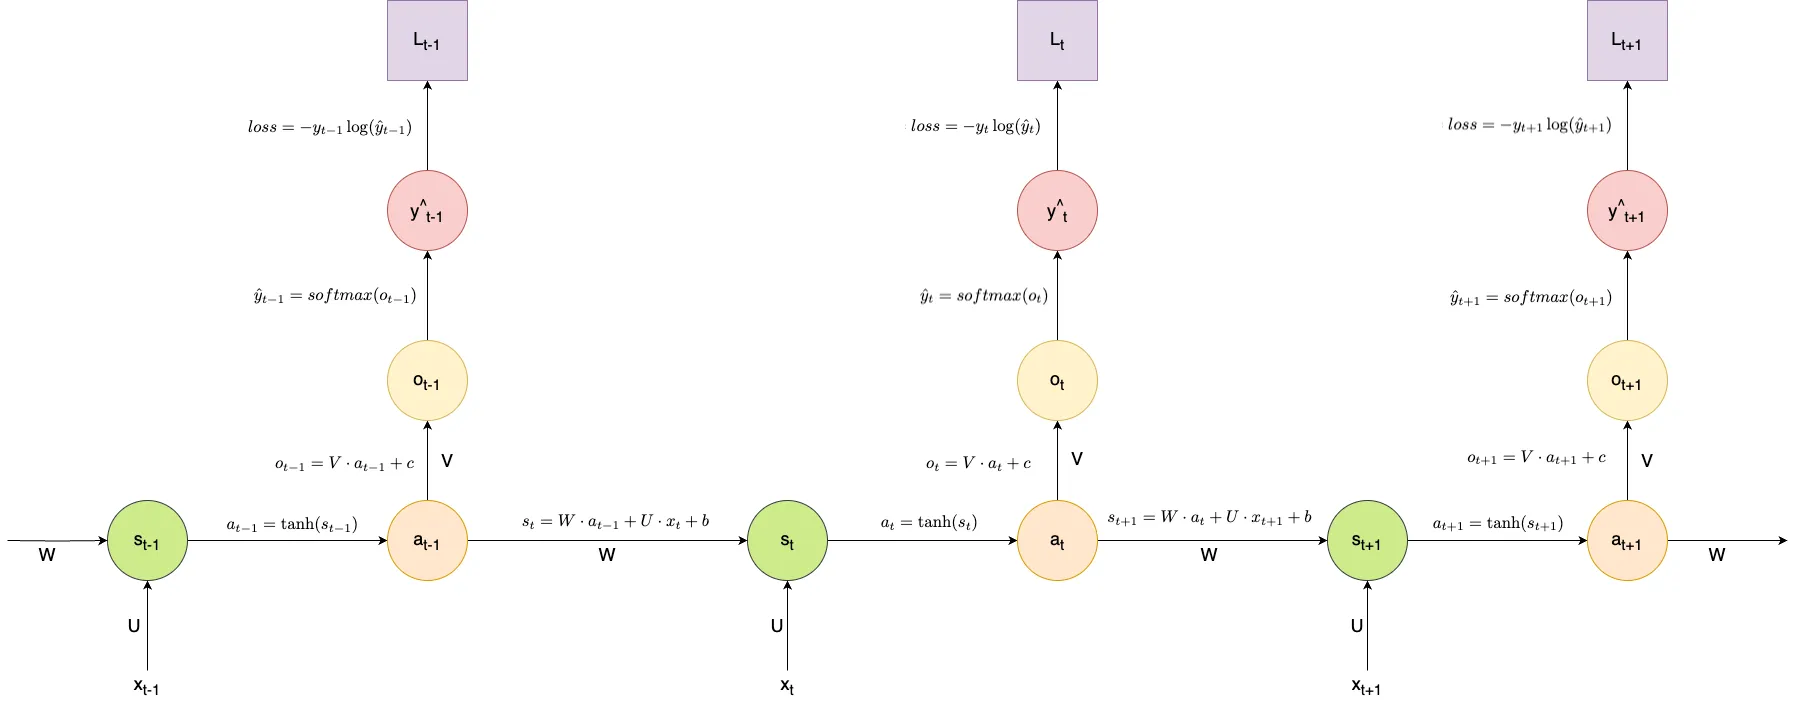

### Input Transformation
1. At each time step $t$, the input vector $x_t$ is transformed by weights:

   $$
   s_t = W \cdot a_{t-1} + U \cdot x_t + b
   $$
   where:
   - $W$ and $U$ are weight matrices for the hidden state and input.
   - $b$ is the bias term.

### Activation Function
2. The hidden state $s_t$ is passed through an activation function (e.g., $\tanh$) to obtain $a_t$:
   $$
   a_t = \tanh(s_t)
   $$

### Output Prediction
3. Output is calculated using weights $V$:
   $$
   o_t = V \cdot a_t + c
   $$
   where $c$ is the output bias.

4. Predicted output $\hat{y}_t$ is generated using the softmax activation function:
   $$
   \hat{y}_t = \text{softmax}(o_t)
   $$

### Loss Calculation
5. Cross-entropy loss is used for each time step:
   $$
   L_t = -y_t \cdot \log(\hat{y}_t)
   $$

### Backpropagation Through Time (BPTT)
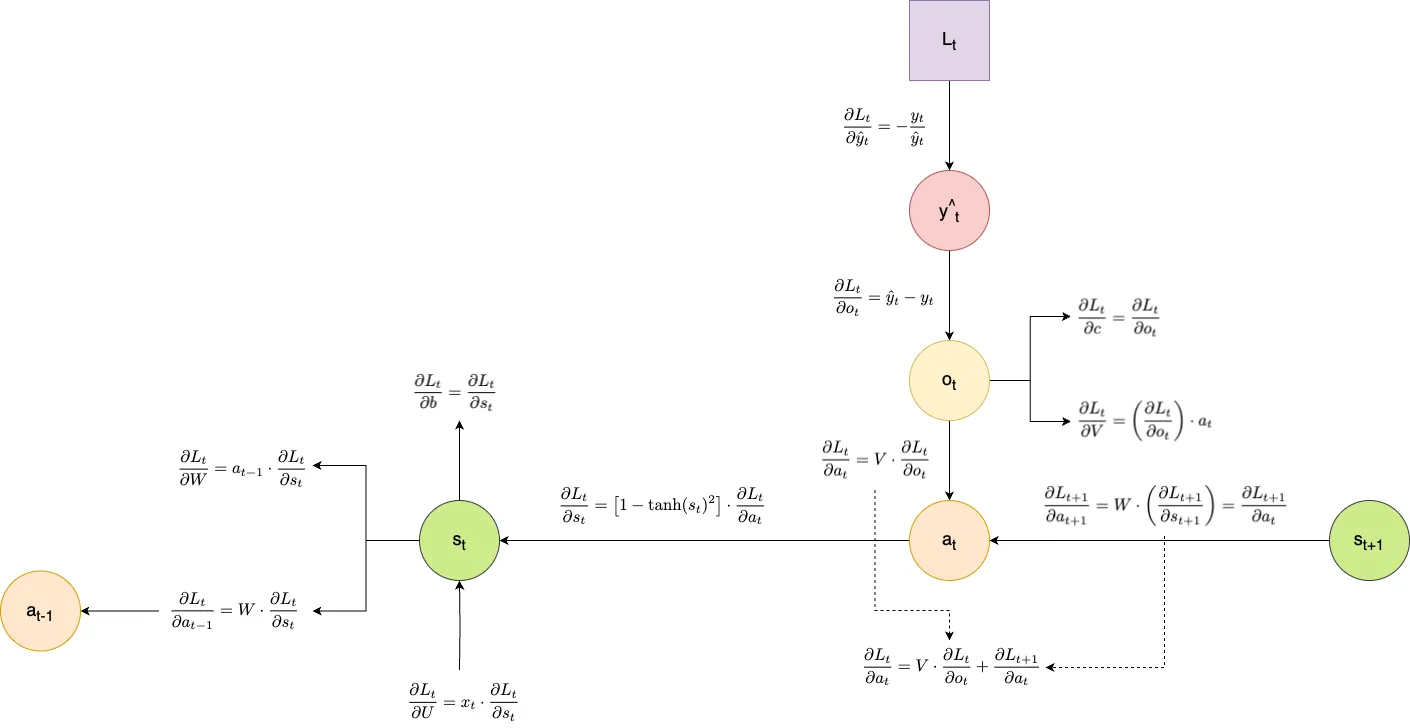
#### Gradients at Output Layer
6. Gradient of loss w.r.t. output $\hat{y}_t$:
   $$
   \frac{\partial L_t}{\partial \hat{y}_t} = \hat{y}_t - y_t
   $$

7. Gradients of weights $V$ and bias $c$:
   $$
   \frac{\partial L_t}{\partial V} = \frac{\partial L_t}{\partial o_t} \cdot a_t
   $$
   $$
   \frac{\partial L_t}{\partial c} = \frac{\partial L_t}{\partial o_t}
   $$

#### Gradients at Hidden State
8. Gradient of $L_t$ w.r.t. $a_t$:
   $$
   \frac{\partial L_t}{\partial a_t} = V \cdot \frac{\partial L_t}{\partial o_t}
   $$
Since the activation at step $t$ contributes both to the output at step $t$ and the activation of the next step $t+1$, we need to add the gradients from the current output and the next time step's loss to get the total gradient of the current activation.

The total gradient of $a_t$ is:

$$
\frac{\partial L}{\partial a_t} = \frac{\partial L_t}{\partial a_t} + W \cdot \frac{\partial L_{t+1}}{\partial a_{t+1}}
$$

This ensures dependencies across time steps are considered when updating weights in RNNs.

9. Gradient of $s_t$:
   $$
   \frac{\partial L_t}{\partial s_t} = (1 - \tanh(s_t)^2) \cdot \frac{\partial L_t}{\partial a_t}
   $$

#### Gradients of Weight Matrices $W$ and $U$
10. For $W$ and $U$:
    $$
    \frac{\partial L_t}{\partial W} = a_{t-1} \cdot \frac{\partial L_t}{\partial s_t}
    $$
    $$
    \frac{\partial L_t}{\partial U} = x_t \cdot \frac{\partial L_t}{\partial s_t}
    $$



In [6]:
import numpy as np

# Sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)

# Hyperparameters
hidden_size = 3   # Hidden layer size
output_size = 1   # Output size
alpha = 0.1       # Learning rate

# Example training data (simple sentences)
data = [
    ("I love this product", 1),   # Positive
    ("This is the worst thing ever", 0),  # Negative
    ("I am so happy with this", 1),  # Positive
    ("I hate this", 0)  # Negative
]

# Create a simple vocabulary and one-hot encoding
vocabulary = ["I", "love", "this", "product", "the", "worst", "thing", "ever", "am", "so", "happy", "with", "hate"]
word_to_index = {word: i for i, word in enumerate(vocabulary)}
input_size = len(vocabulary)  # Update input size based on vocabulary

# Initialize weights
Wxh = np.random.randn(hidden_size, input_size)  # Input to hidden weights
Whh = np.random.randn(hidden_size, hidden_size) # Hidden to hidden weights
Why = np.random.randn(output_size, hidden_size) # Hidden to output weights

# Initialize biases
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))

# Function to convert sentences to one-hot encoding
def one_hot_encode(sentence):
    one_hot_vector = np.zeros((input_size, 1))
    for word in sentence.split():
        if word in word_to_index:
            one_hot_vector[word_to_index[word]] = 1
    return one_hot_vector

# Prepare training data
X = np.array([one_hot_encode(sentence) for sentence, _ in data]).reshape(-1, input_size, 1)  # Reshaping to (num_samples, input_size, 1)
Y = np.array([[label] for _, label in data])

# Forward and backward pass function
def forward_backward(X, Y, h_prev):
    global Wxh, Whh, Why, bh, by  # Declare globals at the beginning
    # Forward pass
    h = sigmoid(np.dot(Wxh, X) + np.dot(Whh, h_prev) + bh)  # Hidden state
    y_pred = sigmoid(np.dot(Why, h) + by)                   # Output prediction
    
    # Calculate loss (Mean Squared Error)
    loss = np.square(Y - y_pred) / 2
    
    # Backward pass
    dy = y_pred - Y                                         # Loss gradient w.r.t y_pred
    dWhy = np.dot(dy, h.T)                                  # Gradient w.r.t Why
    dby = dy                                                # Gradient w.r.t by
    
    dh = np.dot(Why.T, dy) * sigmoid_derivative(h)          # Gradient w.r.t h
    dWxh = np.dot(dh, X.T)                                  # Gradient w.r.t Wxh
    dWhh = np.dot(dh, h_prev.T)                             # Gradient w.r.t Whh
    dbh = dh                                                # Gradient w.r.t bh
    
    # Update weights and biases
    Wxh -= alpha * dWxh
    Whh -= alpha * dWhh
    Why -= alpha * dWhy
    bh -= alpha * dbh
    by -= alpha * dby
    
    return loss, h

# Training loop
epochs = 100
h_prev = np.zeros((hidden_size, 1))

for epoch in range(epochs):
    for x, y in zip(X, Y):  # Iterate through each training example
        loss, h_prev = forward_backward(x, y.reshape(-1, 1), h_prev)  # No need to reshape x, it should be already in correct shape
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.mean():.4f}")

# Test the model with new inputs
def predict(sentence):
    h_prev = np.zeros((hidden_size, 1))
    one_hot_vector = one_hot_encode(sentence)
    h = sigmoid(np.dot(Wxh, one_hot_vector) + np.dot(Whh, h_prev) + bh)
    y_pred = sigmoid(np.dot(Why, h) + by)
    return 1 if y_pred[0][0] > 0.5 else 0

# Example predictions
print("Predicted label for 'This is the worst thing ever':", predict("This is the worst thing ever"))


Epoch 0, Loss: 0.0209
Epoch 10, Loss: 0.0849
Epoch 20, Loss: 0.0619
Epoch 30, Loss: 0.0361
Epoch 40, Loss: 0.0211
Epoch 50, Loss: 0.0129
Epoch 60, Loss: 0.0084
Epoch 70, Loss: 0.0057
Epoch 80, Loss: 0.0041
Epoch 90, Loss: 0.0030
Predicted label for 'This product sucks with sex': 1
Predicted label for 'This is the worst thing ever': 0


![Screenshot (138).png](<attachment:Screenshot (138).png>)

### Code Overview

The code implements a basic RNN to classify sentences as positive or negative sentiment. It involves the following main components:

1. **Activation Function**: The **sigmoid** function is used to introduce non-linearity in the network.

2. **Weight Initialization**: The network has weights connecting the input to the hidden layer (`Wxh`), hidden to hidden layer (`Whh`), and hidden to output layer (`Why`), along with biases (`bh` for hidden and `by` for output).

3. **Data Preparation**: The training data consists of sentences with corresponding labels (1 for positive, 0 for negative). The sentences are converted into one-hot encoded vectors.

4. **Forward and Backward Pass**: The `forward_backward` function performs the forward pass to compute predictions and then calculates gradients for the backward pass to update weights.

5. **Training Loop**: The model is trained over multiple epochs, iterating through each training example.

6. **Prediction Function**: A separate function to make predictions on new input sentences.

### Detailed Explanation

#### 1. **Activation Functions**

```python
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
```

- The **sigmoid function** maps any real-valued number to the range (0, 1). This is useful for modeling probabilities, which is suitable for binary classification tasks.

#### 2. **Weight Initialization**

Weights and biases are initialized randomly and set to zeros:

```python
Wxh = np.random.randn(hidden_size, input_size)  # Input to hidden weights
Whh = np.random.randn(hidden_size, hidden_size) # Hidden to hidden weights
Why = np.random.randn(output_size, hidden_size) # Hidden to output weights
bh = np.zeros((hidden_size, 1))
by = np.zeros((output_size, 1))
```

- `Wxh`: Weights connecting the input layer to the hidden layer.
- `Whh`: Weights connecting the hidden layer to itself (for maintaining the hidden state).
- `Why`: Weights connecting the hidden layer to the output layer.
- `bh` and `by`: Biases for the hidden and output layers.

#### 3. **Data Preparation**

```python
data = [
    ("I love this product", 1),   # Positive
    ("This is the worst thing ever", 0),  # Negative
    ("I am so happy with this", 1),  # Positive
    ("I hate this", 0)  # Negative
]

# Create a simple vocabulary and one-hot encoding
vocabulary = ["I", "love", "this", "product", "the", "worst", "thing", "ever", "am", "so", "happy", "with", "hate"]
word_to_index = {word: i for i, word in enumerate(vocabulary)}
input_size = len(vocabulary)  # Update input size based on vocabulary
```

- The `data` array contains sentences along with their corresponding sentiment labels.
- A vocabulary is created, and a mapping from words to indices is established for one-hot encoding.

```python
def one_hot_encode(sentence):
    one_hot_vector = np.zeros((input_size, 1))
    for word in sentence.split():
        if word in word_to_index:
            one_hot_vector[word_to_index[word]] = 1
    return one_hot_vector
```

- The `one_hot_encode` function converts each sentence into a one-hot encoded vector that represents the presence of each word in the vocabulary.

#### 4. **Forward and Backward Pass Function**

```python
def forward_backward(X, Y, h_prev):
    global Wxh, Whh, Why, bh, by  # Declare globals at the beginning
    # Forward pass
    h = sigmoid(np.dot(Wxh, X) + np.dot(Whh, h_prev) + bh)  # Hidden state
    y_pred = sigmoid(np.dot(Why, h) + by)                   # Output prediction
    
    # Calculate loss (Mean Squared Error)
    loss = np.square(Y - y_pred) / 2
    
    # Backward pass
    dy = y_pred - Y                                         # Loss gradient w.r.t y_pred
    dWhy = np.dot(dy, h.T)                                  # Gradient w.r.t Why
    dby = dy                                                # Gradient w.r.t by
    
    dh = np.dot(Why.T, dy) * sigmoid_derivative(h)          # Gradient w.r.t h
    dWxh = np.dot(dh, X.T)                                  # Gradient w.r.t Wxh
    dWhh = np.dot(dh, h_prev.T)                             # Gradient w.r.t Whh
    dbh = dh                                                # Gradient w.r.t bh
    
    # Update weights and biases
    Wxh -= alpha * dWxh
    Whh -= alpha * dWhh
    Why -= alpha * dWhy
    bh -= alpha * dbh
    by -= alpha * dby
    
    return loss, h
```

- **Forward Pass**:
  - The hidden state `h` is computed using the current input `X`, the previous hidden state `h_prev`, and the biases.
  - The output prediction `y_pred` is calculated based on the hidden state.

- **Loss Calculation**:
  - The loss is calculated using Mean Squared Error (MSE) as the metric to evaluate the performance of the model.

- **Backward Pass**:
  - Gradients of the loss with respect to predictions, weights, and biases are computed using backpropagation. The chain rule is applied to propagate gradients backward through the network.
  
- **Weight Update**:
  - The weights and biases are updated based on the calculated gradients and the learning rate `alpha`.

#### 5. **Training Loop**

```python
for epoch in range(epochs):
    for x, y in zip(X, Y):  # Iterate through each training example
        loss, h_prev = forward_backward(x, y.reshape(-1, 1), h_prev)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.mean():.4f}")
```

- The outer loop runs for a specified number of `epochs`, and the inner loop processes each training example.
- The hidden state is updated for each example, and the loss is printed every 10 epochs to monitor training progress.

#### 6. **Prediction Function**

```python
def predict(sentence):
    h_prev = np.zeros((hidden_size, 1))
    one_hot_vector = one_hot_encode(sentence)
    h = sigmoid(np.dot(Wxh, one_hot_vector) + np.dot(Whh, h_prev) + bh)
    y_pred = sigmoid(np.dot(Why, h) + by)
    return 1 if y_pred[0][0] > 0.5 else 0
```

- The `predict` function takes a sentence as input, encodes it to a one-hot vector, computes the hidden state and prediction, and returns a label based on a threshold (0.5 in this case).

### Conclusion

The provided code implements a simple RNN for sentiment classification. It involves encoding sentences into a suitable format, performing forward and backward passes to learn the weights through training, and predicting sentiment for new sentences. The key concepts illustrated include activation functions, weight initialization, forward and backward propagation, and the training loop. 


---
---
# Understanding the Vanishing Gradient Problem in RNNs

The **vanishing gradient problem** is a significant issue in training Recurrent Neural Networks (RNNs). It occurs when gradients of the loss function become too small as they are propagated backward through the network, making it difficult for the model to learn long-term dependencies.

## Why the Vanishing Gradient Problem Occurs

1. **Activation Functions**:
   - Many activation functions, like the sigmoid or tanh, squash their inputs to a small range (e.g., 0 to 1 for sigmoid). This can lead to very small gradients during backpropagation, especially when the inputs to these functions are large or small.
  
2. **Long Sequences**:
   - In RNNs, as the backpropagation goes through many time steps, the product of small gradients can lead to exponentially small gradients, effectively vanishing by the time they reach the earlier layers of the network.

3. **Weight Initialization**:
   - Poor weight initialization can exacerbate the problem, as it may lead to activation functions saturating early in training, further diminishing the gradients.

## Solutions for the Vanishing Gradient Problem

1. **Weight Initialization**:
   - Using advanced weight initialization techniques like **He initialization** helps to keep the gradients in a suitable range during the early stages of training.

2. **Echo State Networks**:
   - Echo State Networks (ESNs) are a type of RNN that maintains a reservoir of hidden states. The weights to the hidden states are fixed, which helps mitigate the vanishing gradient problem.

3. **Use of LSTM/GRU Networks**:
   - Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) networks are specifically designed to handle long-term dependencies by incorporating gates that control the flow of information, effectively reducing the impact of vanishing gradients.

## Solutions for the Exploding Gradient Problem

While the vanishing gradient problem is significant, RNNs also face the **exploding gradient problem**, where gradients grow exponentially during backpropagation, leading to unstable updates.

### Common Solutions

1. **Truncated Backpropagation**:
   - Limit the backpropagation to a fixed number of time steps, which can prevent the gradients from exploding due to a very long sequence.

2. **Selective Weight Updates**:
   - Instead of updating all the weights, selectively update certain weights to avoid drastic changes during training.

3. **Gradient Clipping**:
   - Implement gradient clipping techniques that cap the gradients at a certain threshold, preventing them from exceeding a specified value.

## Conclusion

The vanishing gradient problem is a common challenge in training RNNs, making it difficult for the model to learn long-term dependencies. Employing solutions such as weight initialization, LSTM/GRU architectures, and techniques for mitigating the exploding gradient problem can significantly improve training effectiveness.


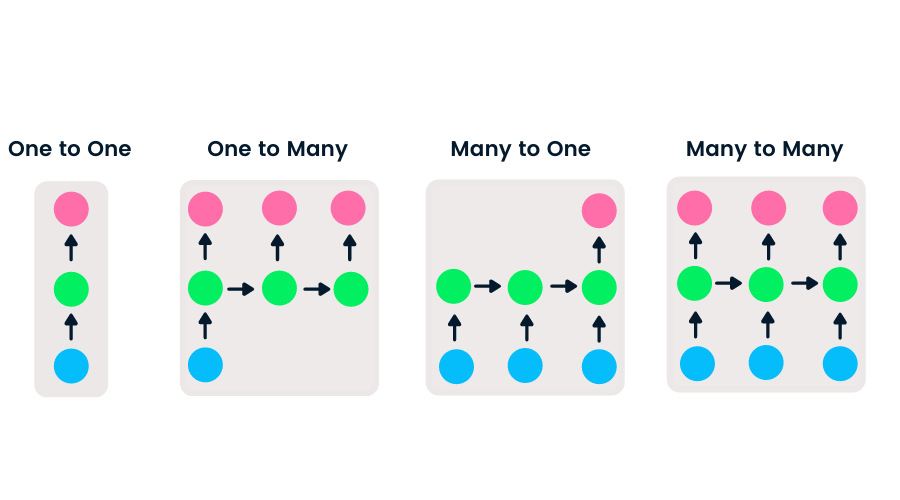